In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

from fbprophet import Prophet

In [2]:
df_sales = pd.read_csv('sales_train_v2.csv')
df_sales['date'] = pd.to_datetime(df_sales['date'],  dayfirst=True)

In [3]:
df_sales_fbprophet = df_sales.loc[(df_sales['item_cnt_day']>0)&
                                (df_sales['item_id']==20949)]
df_sales_fbprophet = df_sales_fbprophet.groupby(['date'])['item_cnt_day'].sum().reset_index(name='item_cnt_day_total')
df_sales_fbprophet


,date,item_cnt_day_total
0,2013-04-24,8.0
1,2013-04-25,25.0
2,2013-04-26,43.0
3,2013-04-27,38.0
4,2013-04-28,38.0
...,...,...
916,2015-10-27,74.0
917,2015-10-28,90.0
918,2015-10-29,92.0
919,2015-10-30,118.0


In [4]:
df_sales_fbprophet = df_sales_fbprophet.rename(columns={"date": "ds", "item_cnt_day_total": "y"})
df_sales_fbprophet['floor']=0
df_sales_fbprophet['cap']=df_sales_fbprophet['y'].max()
df_sales_fbprophet

,ds,y,floor,cap
0,2013-04-24,8.0,0,1137.0
1,2013-04-25,25.0,0,1137.0
2,2013-04-26,43.0,0,1137.0
3,2013-04-27,38.0,0,1137.0
4,2013-04-28,38.0,0,1137.0
...,...,...,...,...
916,2015-10-27,74.0,0,1137.0
917,2015-10-28,90.0,0,1137.0
918,2015-10-29,92.0,0,1137.0
919,2015-10-30,118.0,0,1137.0


In [5]:
m = Prophet(daily_seasonality=False, yearly_seasonality=True, growth='logistic')
m.fit(df_sales_fbprophet)

INFO:numexpr.utils:NumExpr defaulting to 1 threads.


In [6]:
# find how many periods we need by finding the last day in the item
days_to_predict = pd.to_datetime('2015-11-30') - df_sales_fbprophet['ds'].max()
days_to_predict.days

30

In [7]:
# predict a few days into the future so we have a full month in November
future = m.make_future_dataframe(periods=days_to_predict.days)
future['floor']=0
future['cap']=df_sales_fbprophet['y'].max()

future.tail()

,ds,floor,cap
946,2015-11-26,0,1137.0
947,2015-11-27,0,1137.0
948,2015-11-28,0,1137.0
949,2015-11-29,0,1137.0
950,2015-11-30,0,1137.0


In [8]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
946,2015-11-26,109.209270,11.446616,221.064861
947,2015-11-27,140.998174,29.389645,247.227009
948,2015-11-28,209.263372,95.592107,314.385559
949,2015-11-29,146.667629,34.997002,251.032335
950,2015-11-30,64.748620,-36.083833,171.863421


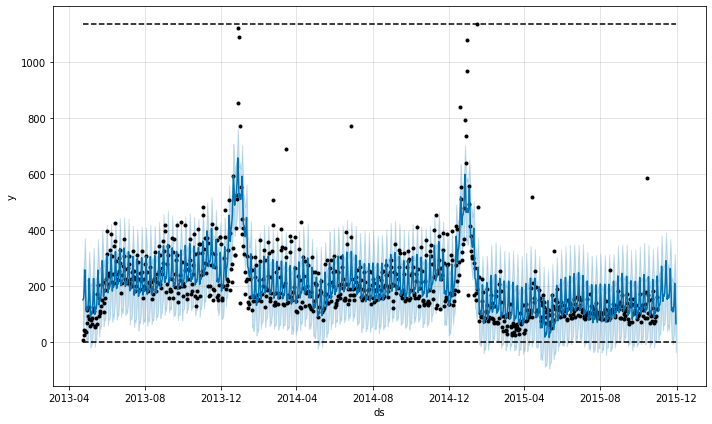

In [9]:
fig1 = m.plot(forecast)

In [10]:
# 30 days of November
forecast['yhat'].tail(30)

921    182.388303
922    109.380706
923    132.770853
924    131.232231
925    146.298387
926    190.631498
927    270.507737
928    218.201137
929    144.873018
930    166.975143
931    163.166126
932    174.992818
933    215.159637
934    290.013917
935    231.928944
936    152.191737
937    167.403779
938    156.394265
939    160.897640
940    193.818517
941    261.712116
942    197.162046
943    111.662592
944    122.013878
945    107.229601
946    109.209270
947    140.998174
948    209.263372
949    146.667629
950     64.748620
Name: yhat, dtype: float64

In [11]:
# forecast for the total month of November 2015
forecast['yhat'].tail(30).sum()

5069.89369081289